# part0: imports

In [1]:
import os, sys, pathlib
from pprint import pprint
import gc
import pickle
from importlib import reload
import logging, warnings
logging.basicConfig(level=logging.ERROR)
warnings.simplefilter("ignore")

import pandas as pd
import numpy as np
import sklearn
from sklearn.decomposition import PCA
import scipy.linalg as linalg

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib as mpl
from matplotlib.ticker import MaxNLocator
from matplotlib.collections import LineCollection
%matplotlib inline


import pyaldata as pyal

if "__file__" not in dir():
    try:
        NBPath = pathlib.Path.cwd()
        RepoPath = NBPath.parent
        os.chdir(RepoPath)

        from tools import utilityTools as utility
        from tools import dataTools as dt
        import params
        reload(params)
        monkey_defs = params.monkey_defs
        mouse_defs = params.mouse_defs

        set_rc =  params.set_rc_params
        set_rc()
        root = params.root

        os.chdir(RepoPath / 'monkey')
        %run "_dataset-selection.ipynb"

    finally:
        os.chdir(NBPath)

    %run "fig1.ipynb"

    print('Done')

the variable `GoodDataList` contains the session names
Done


# Part 1

functions that plot each panel.

---

Raster panel

In [2]:
def prep_example_df():
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        df = pyal.restrict_to_interval(df, epoch_fun=monkey_defs.exec_epoch)
        raster_example_df.append(df)
    return raster_example_df


def plot_moneky_fr_raster(df,gs):
    trial=12
    axes = []
    data = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data.append(df_.M1_rates[trial])
    data = np.array(data)
    vmin = np.amin(data, axis= (0,1))
    vmax = np.amax(data, axis= (0,1))

    for j,tarData in enumerate(data):
        ax = fig.add_subplot(gs[j])
        axes.append(ax)
        tarData -= vmin
        tarData /= (vmax - vmin)
        ax.imshow(tarData.T, aspect='auto')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    axes[0].set_ylabel(f'Units ($n={tarData.shape[1]}$)')
    return axes

def plot_moneky_vel_ex(df,gs):
    trial=12
    axes = []
    for tar in range(monkey_defs.n_targets):
        df_ = pyal.select_trials(df, df.target_id==tar)
        data = df_.vel[trial]
        ax = fig.add_subplot(gs[tar])
        axes.append(ax)
        ax.plot(data[:,0], label='$X$')
        ax.plot(data[:,1], label='$Y$')
        ax.tick_params('both', bottom=False, left=False, labelbottom=False, labelleft=False)
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        ax.spines['bottom'].set_visible(False)
        ax.spines['left'].set_visible(False)
    
    return axes

3D dynamics panel

In [5]:
def plot_monkey_pc_example(raster_example_df, gs):   
    fig=gs.figure
    
    colors = utility.get_colors(8)
    dfs=[]
    axes=[]
    for i,df in enumerate(raster_example_df):
        rates = np.concatenate(df['M1_rates'].values, axis=0)
        rates -= np.mean(rates, axis=0)
        rates_model = PCA(n_components=10, svd_solver='full').fit(rates)
        df_ = pyal.apply_dim_reduce_model(df, rates_model, 'M1_rates', '_pca');
        dfs.append(df_)
        ax = fig.add_subplot(gs[i], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(monkey_defs.n_targets):
            df__ = pyal.select_trials(df_, df_.target_id==tar)
            ex = pyal.get_sig_by_trial(df__,'_pca')
            ex = np.mean(ex, axis=2)[:,:3]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    AllData = dt.get_data_array(raster_example_df, area='M1', model=10)
    data1 = np.reshape(AllData[0,...], (-1,10))
    data2 = np.reshape(AllData[1,...], (-1,10))
    A,B,*_ = dt.canoncorr(data1,data2,fullReturn=True)
    coef_ = [A,B]
    for i,sessionData in enumerate(AllData):
        ax = fig.add_subplot(gs[i+3], projection='3d',fc='None')
        axes.append(ax)
        for tar in range(8):
            ex = np.mean(sessionData[tar,...], axis=0)
            ex = ex @ coef_[i]
            ax.plot(ex[:,0],ex[:,1],ex[:,2],color=colors[tar],lw=1)
            ax.view_init(60,-47)

    titles=[r'Monkey1 (\textit{unaligned})',r'Monkey2 (\textit{unaligned})',
            r'Monkey1 (\textit{aligned})',  r'Monkey2 (\textit{aligned})']
    labels = ['PC','PC','CC','CC']
    for i, ax in enumerate(axes):
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_zticks([])
        ax.set_xlabel(f'{labels[i]}1', labelpad=-15)
        ax.set_ylabel(f'{labels[i]}2', labelpad=-15)
        ax.set_zlabel(f'{labels[i]}3', labelpad=-15)
        ax.set_title(titles[i], y=.9, loc='center')
    
    #======== add the arrow
    
    ax = fig.add_subplot(gs[2], fc='None')
    ax = utility.phantom_axes(ax)
    ax.arrow(0,0,1,0,length_includes_head=True, width=.005, head_width=.015,head_length=.1, ec='k', fc='k')
    ax.set_ylim([-.1,.1])
    ax.set_xlim([-.5,1.1])
    ax.text(0.5,0.01,'CCA', ha='center', va='bottom')
    ax.text(0.5,-0.01,'(alignment)', ha='center', va='top')
    
    return axes

CCA for the example sessions

In [97]:
def plot_cca_for_ex(ax,):
    raster_example = monkey_defs.raster_example
    raster_example_df = []
    for session in raster_example:
        path = root/session.split('_')[0]/session
        df = monkey_defs.prep_general(dt.load_pyal_data(path))
        raster_example_df.append(df)
    
    df1, df2 = raster_example_df
    AllData1 = dt.get_data_array(df1, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(df2, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T
    
    # lower bound
    AllDataL1 = dt.get_data_array(df1, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllDataL2 = dt.get_data_array(df2, monkey_defs.fixation_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllDataL1.shape,AllDataL2.shape),axis=0)
    CCsL=[]
    for sessionData1,sessionData2 in zip(AllDataL1,AllDataL2):
        r = []
        for n in range(params.n_iter * 10):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)
            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T
    
    # upper bound
    AllDataU = dt.get_data_array([df1,df2], monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllDataU.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllDataU):
        r = []
        for n in range(params.n_iter * 10):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,monkey_defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,monkey_defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    ax.plot(x_, allCCs, color=params.colors.MainCC, marker = 'o', label=f'Across monkeys')
    ax.plot(x_, CCsU[:,0], color=params.colors.UpperCC, marker = '<', ls='--', label=f'Within monkey1')
    ax.plot(x_, CCsU[:,1], marker = '<', ls='--', label=f'Within monkey2')
    ax.plot(x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':', label=f'Control')


    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.legend(loc=(.55,.67))
    ax.set_ylabel('Canonical correlation')
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])

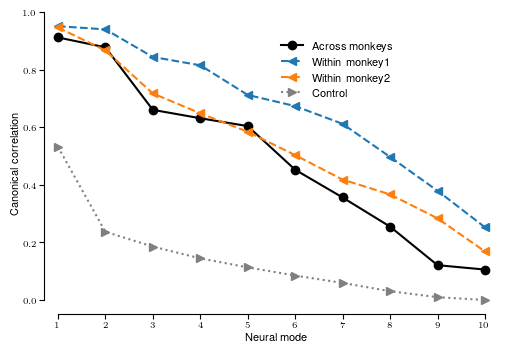

In [65]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig,ax = plt.subplots(dpi=100)
    
    plot_cca_for_ex(ax)
    

---

monkey population CCA plot

In [92]:
def get_full_monkey_data():
    full_list_MCx = []
    for animal, sessionList in GoodDataList[monkey_defs.areas[2]].items():
        if 'Mr' in animal:
            continue  # to remove MrT
        full_list_MCx.append((animal,sessionList))
    full_list_MCx = [(animal,session) for animal,sessions in full_list_MCx for session in set(sessions)]
    # load the DFs
    allDFs_MCx = []
    for animal, session in full_list_MCx:
        path = root/animal/session
        allDFs_MCx.append(monkey_defs.prep_general(dt.load_pyal_data(path)))

    return full_list_MCx, allDFs_MCx

In [110]:
def plot_monkey_cca(ax, ax_hist, full_list_MCx, allDFs_MCx):
    pairFileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            pairFileList1.append((I,J))

    side1df = [allDFs_MCx[i] for i,_ in pairFileList1]
    side2df = [allDFs_MCx[j] for _,j in pairFileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData2 = dt.get_data_array(side2df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData2.shape),axis=0)
    allCCs=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData2):
        data1 = np.reshape(sessionData1[:,:min_trials,:min_time,:], (-1,defs.n_components))
        data2 = np.reshape(sessionData2[:,:min_trials,:min_time,:], (-1,defs.n_components))
        allCCs.append(dt.canoncorr(data1, data2))
    allCCs = np.array(allCCs).T

    # lower bound
    single_FileList1 = []
    for I, (animal1,session1) in enumerate(full_list_MCx):
        for J, (animal2,session2) in enumerate(full_list_MCx):
            if J<=I or animal1 == animal2: continue  # to repetitions
            if 'Chewie' in animal1 and 'Chewie' in animal2: continue 
            single_FileList1.append((I,J))
    n_iter = params.n_iter * 10
    side1df = [allDFs_MCx[i] for i,_ in single_FileList1]
    side2df = [allDFs_MCx[j] for _,j in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.prep_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    AllData1_ = dt.get_data_array(side2df, monkey_defs.fixation_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    _,_, min_trials, min_time,_ = np.min((AllData1.shape,AllData1_.shape),axis=0)

    CCsL=[]
    for sessionData1,sessionData2 in zip(AllData1,AllData1_):
        r = []
        for n in range(n_iter):
            sessionData1_sh = params.rng.permutation(sessionData1,axis=0)
            sessionData2_sh = params.rng.permutation(sessionData2,axis=0)

            data1 = np.reshape(sessionData1_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData2_sh[:,:min_trials,:min_time,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsL.append(r)
    CCsL = np.array(CCsL)
    CCsL = np.percentile(CCsL, 1, axis=1).T

    # Upper bound
    single_FileList1 = []
    for I, _ in enumerate(full_list_MCx):
        single_FileList1.append(I)
    side1df = [allDFs_MCx[i] for i in single_FileList1]
    AllData1 = dt.get_data_array(side1df, monkey_defs.exec_epoch, area=monkey_defs.areas[2], model=monkey_defs.n_components)
    n_shared_trial1 = AllData1.shape[2]
    trialList1 = np.arange(n_shared_trial1)
    CCsU=[]
    for session, sessionData in enumerate(AllData1):
        r = []
        for n in range(n_iter):
            params.rng.shuffle(trialList1)
            # non-overlapping randomised trials
            trial1 = trialList1[:n_shared_trial1//2]
            trial2 = trialList1[-(n_shared_trial1//2):]
            data1 = np.reshape(sessionData[:,trial1,:,:], (-1,defs.n_components))
            data2 = np.reshape(sessionData[:,trial2,:,:], (-1,defs.n_components))
            r.append(dt.canoncorr(data1, data2))
        CCsU.append(r)
    CCsU = np.array(CCsU)
    CCsU = np.percentile(CCsU, 99, axis=1).T

    # plotting
    x_ = np.arange(1,monkey_defs.n_components+1)
    utility.shaded_errorbar(ax, x_, allCCs, color=params.colors.MainCC, marker = 'o')
    utility.shaded_errorbar(ax, x_, CCsU, color=params.colors.UpperCC, marker = '<', ls='--')
    utility.shaded_errorbar(ax, x_, CCsL, color=params.colors.LowerCC, marker = '>', ls=':')

    ax.set_ylim([-.05,1])
    ax.set_xlim([.6,monkey_defs.n_components+.6])
    ax.set_xlabel('Neural mode')
    ax.xaxis.set_major_locator(MaxNLocator(integer=True))
    # ax.set_title(f'{defs.areas[2]} Alignment')
    ax.set_ylabel('Canonical correlation')
    ax.tick_params(axis='y', left=True, right=True)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_bounds([1,monkey_defs.n_components])
    ax.spines['left'].set_bounds([0,1])
    
    #plot the hist

    bins = np.arange(0,1,0.05)
    utility.phantom_axes(ax_hist)
    ax_hist.spines['left'].set_visible(True)
    ax_hist.spines['left'].set_bounds([0,1])
    ax_hist.hist(allCCs[:4,:].mean(axis=0), bins=bins, density=True, label=f'Across ($n={allCCs.shape[1]}$)',
            color=params.colors.MainCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsU[:4,:].mean(axis=0), bins=bins, density=True,label=f'Within ($n={CCsU.shape[1]}$)',
            color=params.colors.UpperCC, alpha=.8, orientation='horizontal')
    ax_hist.hist(CCsL[:4,:].mean(axis=0), bins=bins, density=True, label=f'Control ($n={CCsL.shape[1]}$)',
            color=params.colors.LowerCC, alpha=.8, orientation='horizontal')
    
    ax_hist.legend(loc=(0,0))

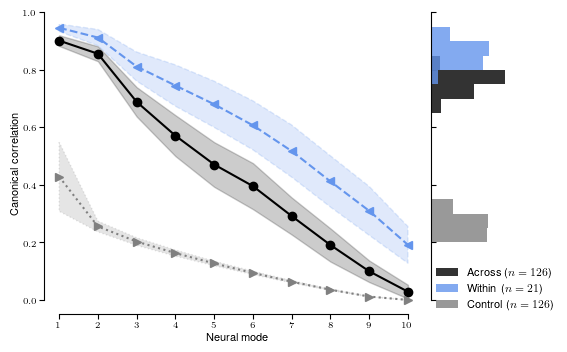

In [111]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    fig=plt.figure(dpi=100)
    gs = fig.add_gridspec(nrows=1, ncols=2, width_ratios=(5,1), wspace=0)

    ax = fig.add_subplot(gs[0])
    ax_ = fig.add_subplot(gs[1], sharey=ax)

    
    # full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax,ax_, full_list_MCx, allDFs_MCx)
    
    plt.show()

# Part 2
Plot figure

In [ ]:
if "__file__" not in dir():
    plt.close('all')
    set_rc()
    figsize=params.LargeFig
    fig=plt.figure(figsize=figsize)
    
   

    ##########################################
    # 1: schematics
    gs1   =utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1], 
                                    width=params.panels.schmatic[0], 
                                    height=params.panels.schmatic[1])
    ax1   =fig.add_subplot(gs1[0])
    ax1 = utility.phantom_axes(ax1)
    ax1.set_facecolor([1,0,0,.3])


    ##########################################
    # 2: Raster
    gs2_1 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    gs2_2 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.raster[1])
    
    gs2_3 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     left=params.panels.schmatic[0],
                                     bottom=figsize[1]-params.panels.schmatic[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])
    gs2_4 = utility.add_gridspec_abs(fig, nrows=1, ncols=monkey_defs.n_targets,
                                     right=figsize[0],
                                     top=figsize[1]-params.panels.raster[1],
                                     width=params.panels.raster[0], 
                                     height=params.panels.velocity[1])

    
    raster_example_df = prep_example_df()
    
    axes2_1 = plot_moneky_fr_raster(raster_example_df[0], gs2_1)
    axes2_2 = plot_moneky_fr_raster(raster_example_df[1], gs2_2)
    utility.phantom_axes(fig.add_subplot(gs2_1[:])).set_title('Monkey1')
    utility.phantom_axes(fig.add_subplot(gs2_2[:])).set_title('Monkey2')
    
    axes2_3 = plot_moneky_vel_ex(raster_example_df[0], gs2_3)
    axes2_4 = plot_moneky_vel_ex(raster_example_df[1], gs2_4)

    axes2_3[0].set_ylabel('Velocity')
    axes2_3[0].set_xlabel('Time rel. to movement onset',loc='left')
    axes2_4[-1].legend(frameon=False, loc=(1.0,.1))
    
    gs2_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, 
                                     height=params.panels.raster[1]-.15, 
                                     width=.1, 
                                     left=figsize[0]+.2, 
                                     bottom=figsize[1]-params.panels.schmatic[1]+params.panels.velocity[1])
    cax2 = fig.add_subplot(gs2_c[:])
    fig.colorbar(cm.ScalarMappable(),cax=cax2, ticks=(0,1),drawedges=False)
    cax2.set_title('Normalised\nfiring rate')


    
    
    ##########################################
    # 3: 3D projections
    gs3   =utility.add_gridspec_abs(fig, nrows=1, ncols=5, left=0, 
                                    bottom=figsize[1]-params.panels.schmatic[1]-params.panels.proj_3d_align[1], 
                                    width=params.panels.proj_3d_align[0], 
                                    height=params.panels.proj_3d_align[1])

    
    axes3 = plot_monkey_pc_example(raster_example_df, gs3)
    
    
    gs3_c = utility.add_gridspec_abs(fig, nrows=1, ncols=1, left=0,
                                    bottom=(axes3[0].get_position().y0+axes3[0].get_position().y1)/2*figsize[1],
                                    width=.2, height=0.2)
    cax3 = fig.add_subplot(gs3_c[0],zorder=10)

    utility.plot_targets(cax3,3)
    cax3.set_xlim(np.array(cax3.get_xlim())*1.15)
    cax3.set_ylim(np.array(cax3.get_ylim())*1.15)

    
    ##########################################
    # 4: CCA plot for the example animals
    gs4   =utility.add_gridspec_abs(fig, nrows=1, ncols=1,
                                    left=0,
                                    bottom=gs3.bottom*figsize[1]-params.panels.cca[1], 
                                    width=params.panels.cca[0],
                                    height=params.panels.cca[1])

    ax4 = fig.add_subplot(gs4[0])
    
    plot_cca_for_ex(ax4)
    

    
    
    ##########################################
    # 5: CCA plot for population
    gs5 = fig.add_gridspec(nrows=1, ncols=2,  width_ratios=(params.panels.cca[0],params.panels.cca_hist[0]-params.panels.cca[0]),
                           left=gs4.right+(1/figsize[0]),  # 1" offset
                           right=gs4.right+ (1/figsize[0]) + params.panels.cca_hist[0]/figsize[0],
                           bottom=gs4.bottom,
                           top=gs4.top,
                           wspace=0)

    ax4 = fig.add_subplot(gs5[0])
    ax4_ = fig.add_subplot(gs5[1], sharey=ax4)

    
    full_list_MCx, allDFs_MCx = get_full_monkey_data()
    
    plot_monkey_cca(ax4,ax4_, full_list_MCx, allDFs_MCx)
    
    
    ##########################################

    # fig.savefig(params.figPath / 'figure1.pdf', format='pdf', bbox_inches='tight')